# Pandas + pySpark

Para este primer ejercicio se utilizará unicamente pandas como viene estándar y se medirán los tiempos de ejecución

## Carga de datos

Los datos para este ejercicio provienen de https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018?select=2018.csv corresponden a vuelos y cancelaciones de 2009 a 2018 repartido en nueve archivos, con un tamaño total de 7,6 GB

### Inicialización SparkSession

Las aplicaciones de PySpark comienzan con la inicialización, *SparkSession* que es el punto de entrada de PySpark como se muestra a continuación. En caso de ejecutarlo en el shell PySpark a través del ejecutable pyspark, el shell crea automáticamente la sesión en la variable spark para los usuarios. https://spark.apache.org/docs/latest/api/python/getting_started/quickstart.html

In [4]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [5]:
spark

In [6]:
spark.sparkContext._conf.getAll()

[('spark.app.id', 'local-1618936853180'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '44573'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '192.168.3.60'),
 ('spark.sql.warehouse.dir',
  'file:/home/datascience3/Opt-Big-Data/pySpark_GB/spark-warehouse'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.app.startTime', '1618936851733')]

In [7]:
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '20g'),
                                        ('spark.app.name', 'Spark Updated Conf'),
                                        ('spark.executor.cores', '3'),
                                        ('spark.cores.max', '4'),
                                        ('spark.driver.memory','20g')])

In [8]:
spark.sparkContext.stop()

In [9]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [10]:
spark.sparkContext._conf.getAll()

[('spark.executor.id', 'driver'),
 ('spark.driver.host', '192.168.3.60'),
 ('spark.cores.max', '4'),
 ('spark.app.name', 'Spark Updated Conf'),
 ('spark.executor.memory', '20g'),
 ('spark.driver.memory', '20g'),
 ('spark.driver.port', '44573'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.startTime', '1618936914525'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.cores', '3'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.warehouse.dir',
  'file:/home/datascience3/Opt-Big-Data/pySpark_GB/spark-warehouse'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1618936914638')]

In [11]:
import timeit
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from pyspark.sql import functions as F
pd.options.mode.chained_assignment = None
plt.style.use('ggplot')

In [12]:
def plot_time(time_list, name):
    plt.figure(figsize=(14, 4))
    p = sum(time_list) / num
    plt.scatter(range(len(load_data)), time_list, color='blue')
    plt.title('Tiempo por ejecución de: {}, tiempo promedio {} seg'.format(name, round(p, 3)))
    plt.hlines(y=p, xmin=0, xmax=len(time_list), color='red')
    plt.ylabel('Tiempo en segundos')
    plt.xlabel('Ejecuciones')
    plt.show()

In [13]:
# numero de veces a repetir cada prueba
num = 5

In [34]:
FOLDER_DATA = '/home/datascience3/Data_Test/Data_7GB/'
FILE = '2009.csv'

In [35]:
df = spark.read.csv(FOLDER_DATA + FILE,
                        header=True,
                        inferSchema='true')

In [36]:
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: do

In [37]:
df.count()

4623938

In [38]:
load_data = []
for i in range(num):
    start_time = timeit.default_timer()
    df = spark.read.csv(FOLDER_DATA + FILE, header=True, inferSchema='true')
    load_data.append(timeit.default_timer() - start_time)

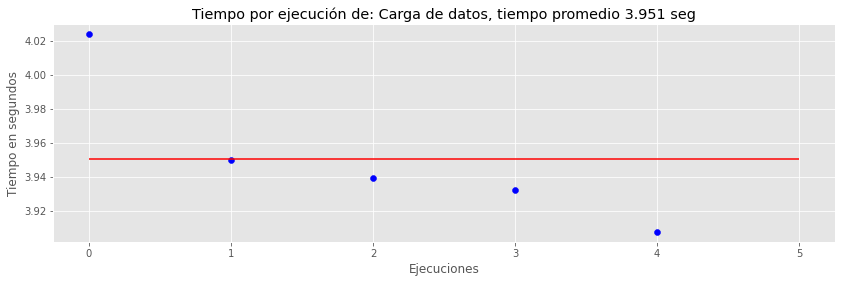

In [39]:
plot_time(load_data, name='Carga de datos')

### Carga de datos varios dataset

In [40]:
%%time
df_big = spark.read.format('csv') \
                   .option('header',True) \
                   .option('multiLine', True) \
                   .load(FOLDER_DATA)

CPU times: user 1.66 ms, sys: 855 µs, total: 2.51 ms
Wall time: 414 ms


In [41]:
%%time
df_big.count()

CPU times: user 15.8 ms, sys: 754 µs, total: 16.6 ms
Wall time: 1min 25s


52056265

## Agrupación por OP_CARRIER

En esta prueba se realizaran las siguientes operaciones:
1. Se agrupan los comentarios por el OP_CARRIER de la cuenta
2. Se organizan por la cantidad de registros
3. Se reinicia el indice de los datos resultantes

In [42]:
g_data = []
for i in range(num):
    start_time = timeit.default_timer()
    df = spark.read.format('csv') \
                   .option('header',True) \
                   .option('multiLine', True) \
                   .load(FOLDER_DATA)
    df_group_page = df.groupBy('OP_CARRIER').count()
    df_group_page.show()
    g_data.append(timeit.default_timer() - start_time)

+----------+-------+
|OP_CARRIER|  count|
+----------+-------+
|        UA|4030404|
|        NK| 481768|
|        AA|5635596|
|        NW| 215208|
|        EV|4080247|
|        B6|2107069|
|      null|      1|
|        DL|6681756|
|      14.0|      1|
|        OO|5283840|
|        F9| 759568|
|       UAR|      1|
|        YV| 837993|
|        US|2320063|
|        MQ|2727937|
|        OH| 454181|
|        HA| 630277|
|       DFW|      1|
|       759|      1|
|        XE|1016266|
+----------+-------+
only showing top 20 rows

+----------+-------+
|OP_CARRIER|  count|
+----------+-------+
|        UA|4030404|
|        NK| 481768|
|        AA|5635596|
|        NW| 215208|
|        EV|4080247|
|        B6|2107069|
|      null|      1|
|        DL|6681756|
|      14.0|      1|
|        OO|5283840|
|        F9| 759568|
|       UAR|      1|
|        YV| 837993|
|        US|2320063|
|        MQ|2727937|
|        OH| 454181|
|        HA| 630277|
|       DFW|      1|
|       759|      1|
|       

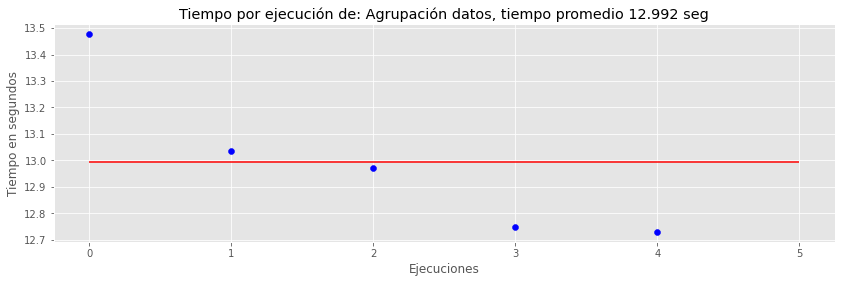

In [43]:
plot_time(g_data, name='Agrupación datos')

In [44]:
s_data = []
for i in range(num):
    start_time = timeit.default_timer()
    df_group_page = df_group_page.orderBy("count",ascending=False)
    df_group_page.show()
    s_data.append(timeit.default_timer() - start_time)

+----------+--------+
|OP_CARRIER|   count|
+----------+--------+
|        WN|10294845|
|        DL| 6681756|
|        AA| 5635596|
|        OO| 5283840|
|        EV| 4080247|
|        UA| 4030404|
|        MQ| 2727937|
|        US| 2320063|
|        B6| 2107069|
|        AS| 1377071|
|        FL| 1060109|
|        XE| 1016266|
|        YV|  837993|
|        F9|  759568|
|        9E|  757691|
|        CO|  670053|
|        HA|  630277|
|        NK|  481768|
|        OH|  454181|
|        VX|  348174|
+----------+--------+
only showing top 20 rows

+----------+--------+
|OP_CARRIER|   count|
+----------+--------+
|        WN|10294845|
|        DL| 6681756|
|        AA| 5635596|
|        OO| 5283840|
|        EV| 4080247|
|        UA| 4030404|
|        MQ| 2727937|
|        US| 2320063|
|        B6| 2107069|
|        AS| 1377071|
|        FL| 1060109|
|        XE| 1016266|
|        YV|  837993|
|        F9|  759568|
|        9E|  757691|
|        CO|  670053|
|        HA|  630277|
|     

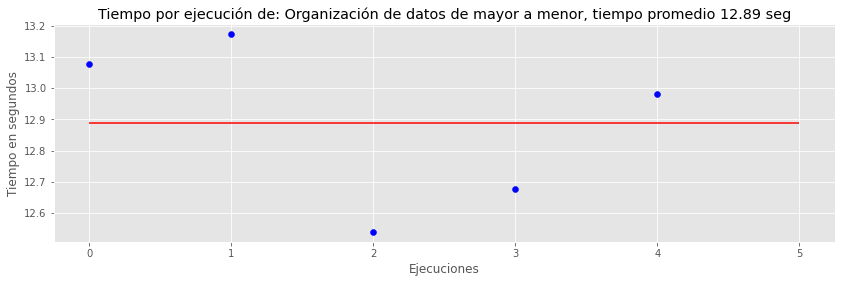

In [45]:
plot_time(s_data, name='Organización de datos de mayor a menor')

## Agrupación de datos por cuentas y publicaciones

En esta prueba se realizaran las siguientes operaciones:
1. Se agrupan los comentarios por el id de la cuenta y la publicación es decir los comentarios por cuenta y publicación
2. Se organizan por la cantidad de comentarios
3. Se reinicia el indice de los datos resultantes

In [46]:
g_data2 = []
for i in range(num):
    start_time = timeit.default_timer()
    df = spark.read.format('csv') \
                   .option('header',True) \
                   .option('multiLine', True) \
                   .load(FOLDER_DATA)
    df_group_pub = df.groupBy('ORIGIN').agg({'OP_CARRIER': 'last',
                                             'OP_CARRIER_FL_NUM': 'count'})
    df_group_pub.show()
    g_data2.append(timeit.default_timer() - start_time)

+------+----------------+------------------------+
|ORIGIN|last(OP_CARRIER)|count(OP_CARRIER_FL_NUM)|
+------+----------------+------------------------+
|   BGM|              9E|                    4196|
|   DLG|              AS|                     647|
|   INL|              OO|                    3195|
|   PSE|              B6|                    6775|
|   MSY|              FL|                  357946|
|   PPG|              HA|                     551|
|   DRT|              EV|                     547|
|   GEG|              9E|                   93577|
|   BUR|              B6|                  210020|
|   SNA|              US|                  351389|
|   GRB|              OO|                   43140|
|   GTF|              OO|                   15763|
|   IFP|              OO|                     313|
|   IDA|              OO|                   23446|
|   GRR|              MQ|                  101412|
|   LWB|              EV|                    1310|
|   JLN|              MQ|      

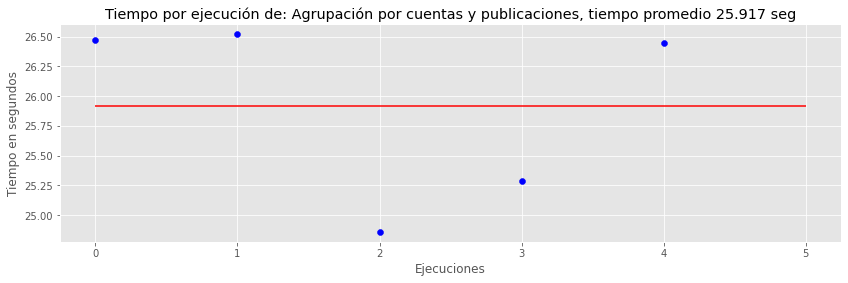

In [47]:
plot_time(g_data2, name='Agrupación por cuentas y publicaciones')

In [48]:
s_data = []
for i in range(num):
    start_time = timeit.default_timer()
    df_group_pub = df_group_pub.orderBy("count(OP_CARRIER_FL_NUM)",ascending=False)
    df_group_pub.show()
    s_data.append(timeit.default_timer() - start_time)

+------+----------------+------------------------+
|ORIGIN|last(OP_CARRIER)|count(OP_CARRIER_FL_NUM)|
+------+----------------+------------------------+
|   ATL|              9E|                 3324524|
|   ORD|              AA|                 2536843|
|   DFW|              OO|                 2155517|
|   DEN|              FL|                 1954252|
|   LAX|              VX|                 1810339|
|   PHX|              HA|                 1472385|
|   IAH|              UA|                 1422171|
|   SFO|              VX|                 1363364|
|   LAS|              HA|                 1253463|
|   CLT|              9E|                 1105531|
|   DTW|              9E|                 1067289|
|   MCO|              DL|                 1052790|
|   MSP|              9E|                 1047672|
|   EWR|              9E|                 1001261|
|   BOS|              WN|                  988307|
|   SLC|              9E|                  977943|
|   SEA|              WN|      

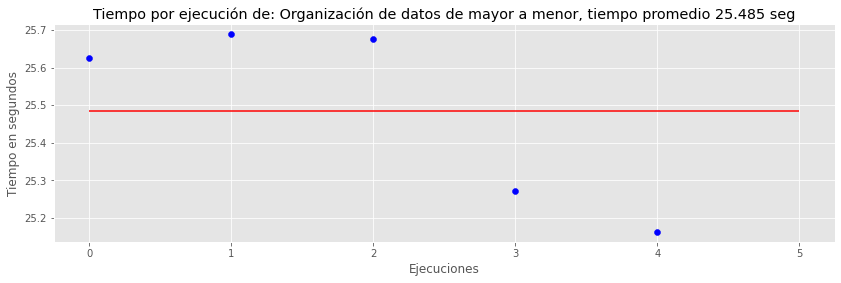

In [49]:
plot_time(s_data, name='Organización de datos de mayor a menor')

In [50]:
df_group_pub.count()

387